# 1. Deutsch-Jozsa Algorithm

May 21, 2021 Yuri Kobayashi <br/>
For University of Tokyo　Special Lectures in Information Science II: <br>Introduction to Near-Term Quantum Computing  <br/>

## Qiskit Implementation <a id='implementation'></a>

Let us implement the Deutsch-Jozsa algorithm with three qubits, with both constant and balanced oracles.

In [1]:
# import qiskit and necessary python libraries
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram

In [2]:
#check qiskit version
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

Next, we set the size of the input register for our function:

In [3]:
# set the length of the n-bit input string. 
n = 3

### 1.1 Constant Function <a id='const_function'></a>
Let's see some ways we can create quantum oracles.
For a constant function, it is simple. We want to make sure no matter what the input is, the ouput would be the same. 

$\qquad$ 1. If f(x) = 0, apply the $I$ gate to qubit register 2.  (here we will do nothing)
$\qquad$ 2. If f(x) = 1, apply the $X$ gate to the qubit in register 2.
Let's start by creating a constant function, in this case the input has no effect on the ouput so we just randomly set the output qubit to be 0 or 1:

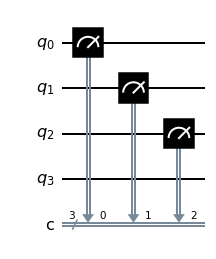

In [4]:
const_function = QuantumCircuit(n+1,n)

output = 0  #ouput qubit is randomly set to be 0 or 1
if output == 1:
    const_function.x(n)
for i in range(n):
    const_function.measure(i, i)
const_function.draw('mpl')

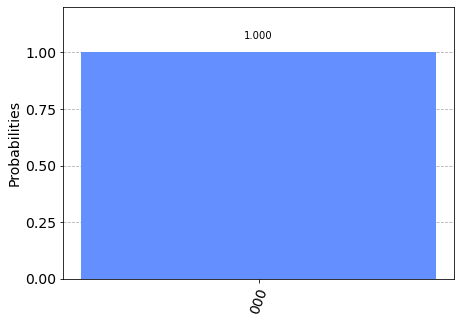

In [5]:
#check that you always get 000 no matter what the output is
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(const_function, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

### 1.2 Balanced Function <a id='balanced_function'></a>

For a balanced function, there are many different ways to create the circuit. For example, one way we can guarantee our circuit is balanced is by performing a CNOT for each input qubit, with the last qubit as the target. For example:

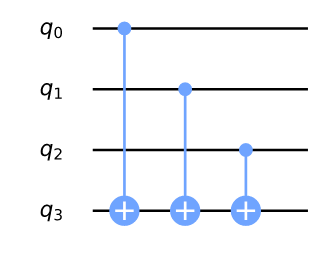

In the image above, the top three qubits form the input register, and the bottom qubit is the output register. 

### Exercise 1.2
When will the above circuit give us an output '0' or an output '1'?<br>
Try applyting the 8 different possible inputs for a 3qubit system (i.e. |𝑞2𝑞1𝑞0⟩=|000⟩, |001⟩, |010⟩, |011⟩, |100⟩, |101⟩, |110⟩, |111⟩) and group them according the outcome. <br>

| Outputs 0 | Outputs 1 |
|:---:     |:---:    |
|        |       |
|        |       |
|        |       |
|        |       |

We can see which states give which output in the table below. Note that there are equal number of results that give you either an ouput 0 or a 1. Showing that it is balanced.

| Outputs 0 | Outputs 1 |
|:---------:|:---------:|
|    000    |    001    |
|    011    |    100    |
|    101    |    010    |
|    110    |    111    |


We can change the results while keeping them balanced by wrapping selected controls in X-gates.

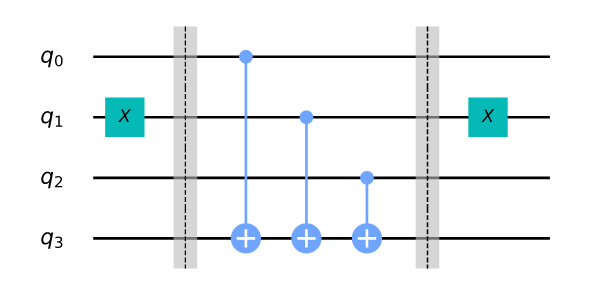

### Exercise 1.3
Build the same circuit using Qiskit with input |𝑞2𝑞1𝑞0⟩=|010⟩ and verify the ouput on |𝑞3⟩

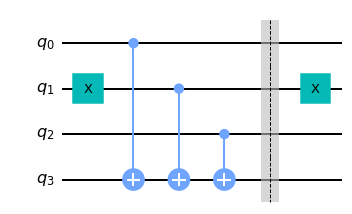

In [6]:
#　Build a circuit with input |𝑞2𝑞1𝑞0⟩=|010⟩ and examine results on output register |𝑞3⟩

q = QuantumCircuit(4)    # prepare 4 qubit circuit

q.x(1)   # apply x gate on our control qubit 𝑞1

# apply cnots across the input and output qubits
q.cx(0,3)
q.cx(1,3)
q.cx(2,3)

q.barrier() # barrier for visual purpose

q.x(1)   # wrap the control with x gate

q.draw(output="mpl")    # draw circuit

Verify that we can change results by keeping them balanced. 

| Outputs 0 | Outputs 1 |
|:---------:|:---------:|
|    001    |    000    |
|    010    |    011    |
|    100    |    101    |
|    111    |    110    |

### Let's create a balanced function

We can create a balanced function by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length `n` that dictates which controls to wrap:

In [7]:
balanced_function = QuantumCircuit(n+1,n)

In [8]:
b_str = "111"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in `b_str` is `1`, or do nothing if the digit is `0`.

In [9]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_function.x(qubit)
balanced_function.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘
q_3: ─────
          
c: 3/═════

Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target:

In [10]:
balanced_function.barrier()   #visual aid

for qubit in range(n):    #cx gates on all input qubits
    balanced_function.cx(qubit, n)

balanced_function.barrier() #visual aid
balanced_function.draw()

┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     ├───┤ ░   │             ░ 
q_1: ┤ X ├─░───┼────■────────░─
     ├───┤ ░   │    │        ░ 
q_2: ┤ X ├─░───┼────┼────■───░─
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░─
           ░ └───┘└───┘└───┘ ░ 
c: 3/══════════════════════════

We finish by wrapping the controls with x-gates.

In [11]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_function.x(qubit)
        
balanced_function.draw()

┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     ├───┤ ░   │             ░ ├───┤
q_1: ┤ X ├─░───┼────■────────░─┤ X ├
     ├───┤ ░   │    │        ░ ├───┤
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░      
c: 3/═══════════════════════════════

We have just created a balanced function. Now let us implement these functions into the Deutsch-Josza algorithm to solve it.

### 1.3 The Full Algorithm <a id='full_alg'></a>

To create a full algorithm, we are going to combine each step of the algorithm with the balanced function we just created. This first step in the algorithm is to initialise the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

In [12]:
#Let's call our circuit for the full algorithim "dj"
dj = QuantumCircuit(n+1, n)

#Step 1: Start with |0>|1>
dj.x(n) #apply x gates

#Step 2: #Step 2: Apply Hadamard on all qubits and make the auxiliary qubit |−⟩
dj.barrier()
for qubit in range(n+1):  #apply hadamard to all qubits
    dj.h(qubit)

#Step 3: Apply Uf |𝑥⟩|𝑦⟩↦|𝑥⟩|𝑓(𝑥)⊕𝑦⟩   
dj += balanced_function  #Add balanced function
dj.draw()

#Step 4: Apply a Hadamard to the last register
dj.barrier()

for qubit in range(n):
    dj.h(qubit)

for i in range(n):
    dj.measure(i, i)

dj.draw()

<ipython-input-12-f95ba59e73a7>:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj += balanced_function  #Add balanced function
/home/keisuke/miniconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


░ ┌───┐┌───┐ ░                 ░ ┌───┐ ░ ┌───┐┌─┐      
q_0: ──────░─┤ H ├┤ X ├─░───■─────────────░─┤ X ├─░─┤ H ├┤M├──────
           ░ ├───┤├───┤ ░   │             ░ ├───┤ ░ ├───┤└╥┘┌─┐   
q_1: ──────░─┤ H ├┤ X ├─░───┼────■────────░─┤ X ├─░─┤ H ├─╫─┤M├───
           ░ ├───┤├───┤ ░   │    │        ░ ├───┤ ░ ├───┤ ║ └╥┘┌─┐
q_2: ──────░─┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├─░─┤ H ├─╫──╫─┤M├
     ┌───┐ ░ ├───┤└───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ░ └───┘ ║  ║ └╥┘
q_3: ┤ X ├─░─┤ H ├──────░─┤ X ├┤ X ├┤ X ├─░───────░───────╫──╫──╫─
     └───┘ ░ └───┘      ░ └───┘└───┘└───┘ ░       ░       ║  ║  ║ 
c: 3/═════════════════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

### Running our circuit on a simulator

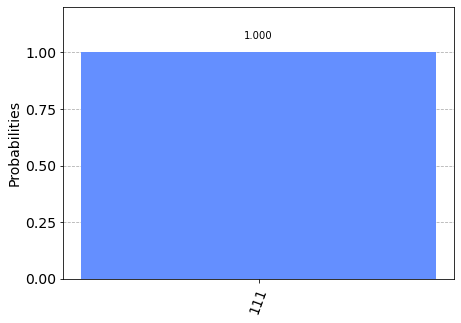

In [13]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We can see from the results above we measure `111` with 100% probability. This correctly predicts the function is balanced. 

### Running our circuit on a real device
Let us try running our circuit on a real device that is least busy.

In [14]:
# For those who are running on a real device for the first time
# from qiskit import IBMQ
# IBMQ.save_account('MY_API_TOKEN')    # insert your API token

In [15]:
#Load IBM Q account and set provider
# IBMQ.load_account()
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#Find the least busy backend
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_santiago


In [ ]:
# Step 1　Construct secret binary string
s = '011001'

n = len(s)
qc = QuantumCircuit(n+1,n)

qc.x(n) #apply x gate
qc.barrier() #visual aid
qc.h(range(n+1)) #Apply hadamard gates to close circuit
qc.barrier() #visual aid
for ii, yesno in enumerate(reversed(s)):
    if yesno == '1': 
        qc.z(ii)

qc.barrier() # visual aid
qc.h(range(n+1)) #apply h gates

qc.barrier() #visual aid

qc.measure(range(n), range(n)) #Measure the input n qubits from 0 to n-1 and store the result in a classical register

qc.draw(output='mpl') #draw circuit

In [ ]:
#Run the job on the least busy backend 
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj, backend=backend, shots=shots, optimization_level=3)

#Monitor job status
job_monitor(job, interval = 2)

In [ ]:
#Obtain job results and get counts
results = job.result()
answer = results.get_counts()

# Plotting answer in histogram
plot_histogram(answer)

Verify that you were able to get the answer `111` with the highest probability. The other answers you see are due to errors present in our near-term quantum systems.

## References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

## 2. Bernstein Vazirani Algorithm <a id='device'></a>

We can implement Bernstein Vazirani algorithm using Qiskit in  five steps. 

1. Set n + 1 qubits and the secret string s.
2. Initialize the first 𝑛 qubits in the state |0⟩, and the last qubit in the |1⟩ state. In Qiskit, all qubits are initialized in the |0⟩ state, so only need to initialize the last qubit to |1⟩ state by applying an X gate.
3. Apply Hadamard gates to all qubits.
4. Build the box containing the secret number (also known as an oracle). We will build it as a function that computes 𝑠・𝑥 modulo 2 by applying CNOT gates from the first 𝑛 qubits onto the last qubit whenever there is a 1 in the secret number. We will do this in reverse order, meaning that the there will be a CNOT gate from the 𝑛th qubit to the last qubit if the first bit of the secret number is 1. 
5. Apply a Hadamard to each qubit and Measure the first 𝑛 qubits. 

In [51]:
#Initialize if necessary
%matplotlib inline
from qiskit import *
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

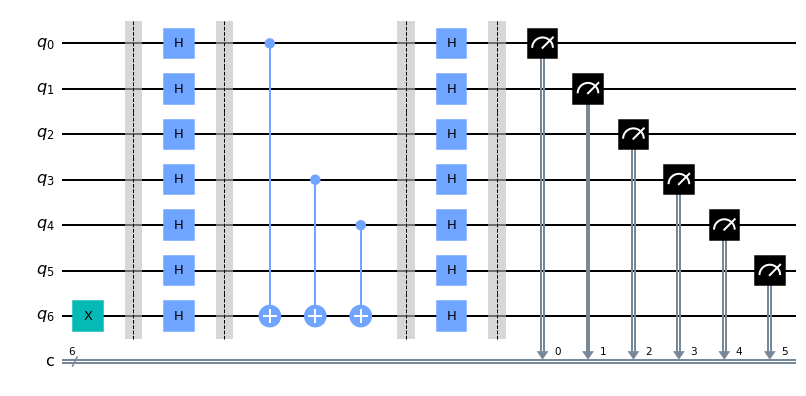

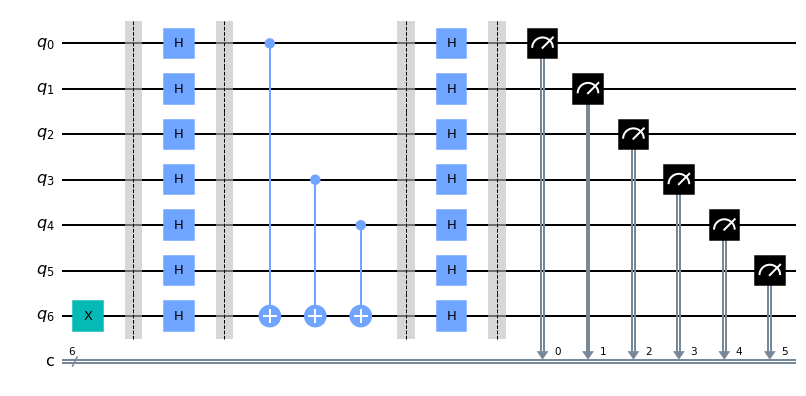

In [54]:
# Step 1　Construct secret binary string
s = '011001'


#Create quantum circuit called 'qc' 
#Prepare n+1 qubits and n classical registers to store results. n should be tne same length as s.
n = len(s)
qc = QuantumCircuit(n+1,n)



# Step 2　Initialize the last auxiliary qubit to |1⟩

qc.x(n) #apply x gate

qc.barrier() #visual aid

# Step 3 Apply Hadamard Gates

qc.h(range(n+1)) #Apply hadamard gates to close circuit

qc.barrier() #visual aid


# Step 4　Build oracle that performs  𝑠・𝑥 modulo 2 by applying CNOT gates

for ii, yesno in enumerate(reversed(s)):
    if yesno == '1': 
        qc.cx(ii, n)

qc.barrier() # visual aid


# Step 5 Apply hadamard gates on input register and measure

qc.h(range(n+1)) #apply h gates

qc.barrier() #visual aid

qc.measure(range(n), range(n)) #Measure the input n qubits from 0 to n-1 and store the result in a classical register

qc.draw(output='mpl') #draw circuit

### 2.1 Running our circuit on a simulator

In [ ]:
# Run circuit on qasm simulator
simulator = Aer.get_backend('qasm_simulator')
# shots=1
result = execute(qc, backend=simulator, shots=1).result()
# plot results
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(qc))

### 2.3 Running our circuit on a real device
Let us try running our circuit on a real device that is least busy.

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
# IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(qc, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

In [ ]:
# filter = {'hubInfo.hub.name': 'ibm-q'}
# job_list = backend.jobs(limit=5, db_filter=filter)
job_list = backend.jobs()[0]
print(job_list)

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

#plot_histogram(answer,figsize=(20,7))
plot_histogram(answer)

Verify that the results show the secret binary string. Other answers are due to error in the near-term quantum system.

## 2.4 References

#### Journal Papers

1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, <a id='1' href='https://doi.org/10.1137/S0097539796300921'>doi:10.1137/S0097539796300921</a>).

#### Tutorials
For detailed information about Qiskit, check out the tutorials in the Github repository:

https://github.com/Qiskit/qiskit-iqx-tutorials

For details on the Bernstein-Vazirani algorithm, check out the open-source `Learn Quantum Computation using Qiskit` textbook:

https://community.qiskit.org/textbook/